## Sample Analysis

In [28]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

# with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
#     sample_data1 = pickle.load(file)
# print(sample_data1.keys())

# with open('/srv/scratch/z5297792/Sample/500plus_sample_data.pkl', 'rb') as file:
#     sample_data2 = pickle.load(file)
# print(sample_data2.keys())

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
print(frontier_sample_data.keys())


dict_keys(['Eddy8', 'Eddy9', 'Eddy22', 'Eddy32', 'Eddy60', 'Eddy110', 'Eddy117', 'Eddy124', 'Eddy133', 'Eddy134', 'Eddy141', 'Eddy142', 'Eddy149', 'Eddy151', 'Eddy161', 'Eddy171'])
dict_keys(['Eddy739', 'Eddy745', 'Eddy749', 'Eddy761', 'Eddy775', 'Eddy788', 'Eddy790', 'Eddy792', 'Eddy797', 'Eddy827'])
dict_keys(['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775'])


In [29]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from matplotlib.patches import Ellipse

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

eddy = 'Eddy22' # AE no-tilt # good \
eddy = 'Eddy110' # AE tilt # good off my own analysis \
eddy = 'Eddy134' # CE non-tilt # best \
eddy = 'Eddy133' # CE tilt \
\
eddy = 'Eddy790' # AE non-tilt # best \
eddy = 'Eddy761' # CE non-tilt # not bad \
eddy = 'Eddy749' # CE tilt # good \
eddy = 'Eddy775' # CE tilt # best \
\
The Sample Frontiers: \
\
AE790 no-tilt \
AE110 tilt \
CE134 no-tilt \
CE775 tilt 




## The Frontiers

In [93]:
# cap everything at COWs depth
d_df = pd.DataFrame()
for eddy in the_frontier_eddies:
    for t in range(30):
        df = frontier_sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]


np.int64(20)

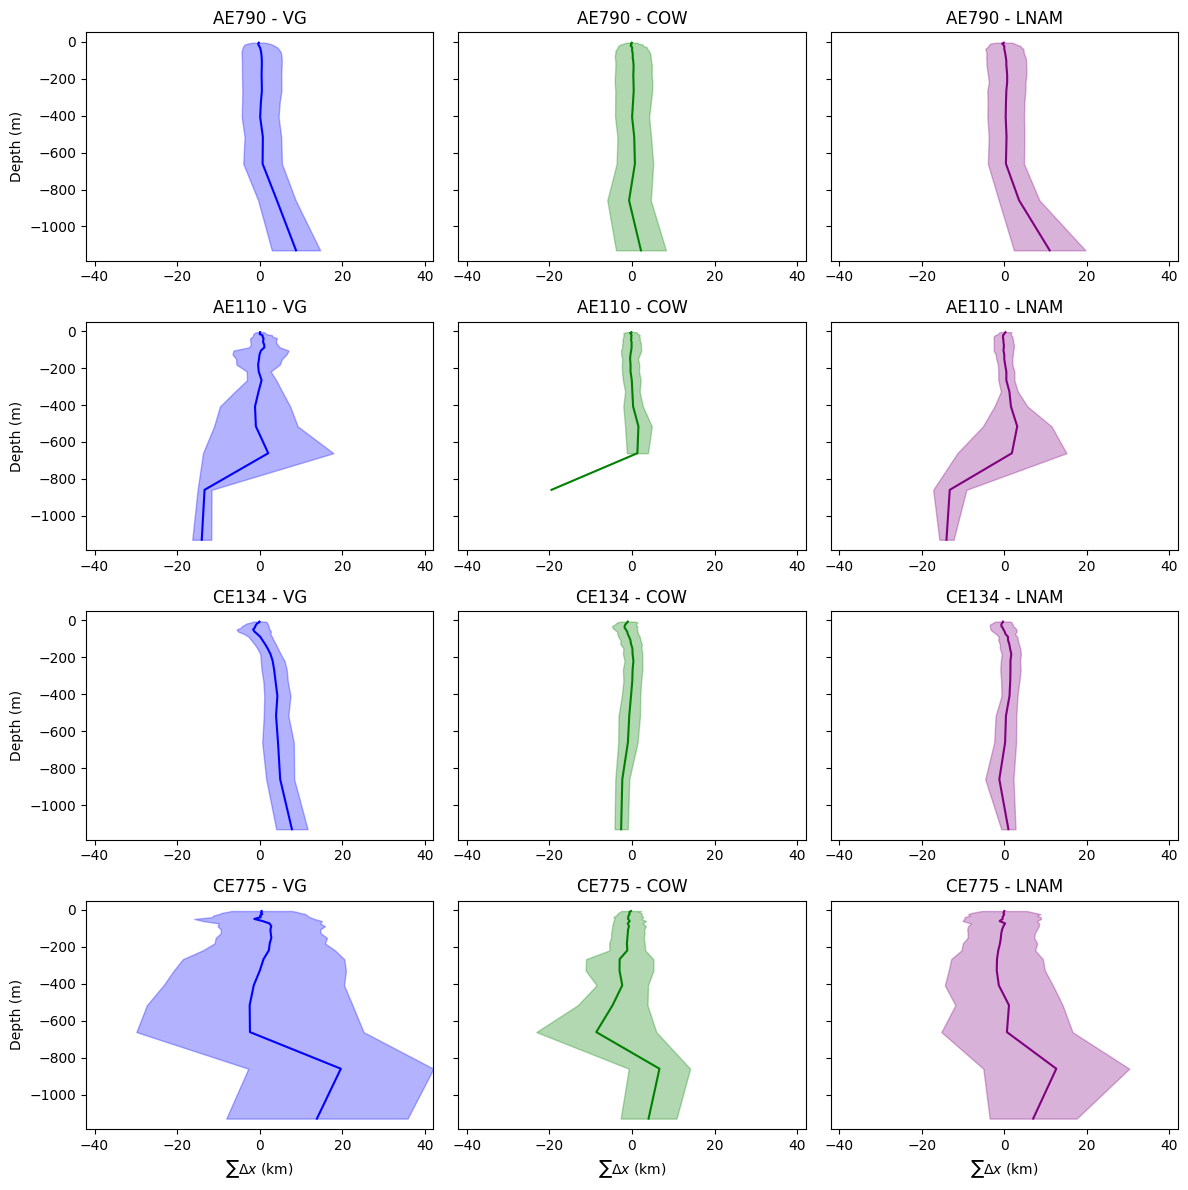

In [94]:
the_frontier_eddies = ['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']

method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        x_df = pd.DataFrame({f'T{t}': frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_df['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x'] for t in range(30)})
        x_mean, x_std = x_df.diff().cumsum().mean(axis=1)/1000, x_df.diff().cumsum().std(axis=1)/1000
        ax.plot(x_mean, z_r[150, 150, :len(x_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(x_mean)], x_mean - x_std, x_mean + x_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta x$ (km)")

        xmin = min(np.nanmin(x_mean - x_std), xmin)
        xmax = max(np.nanmax(x_mean + x_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

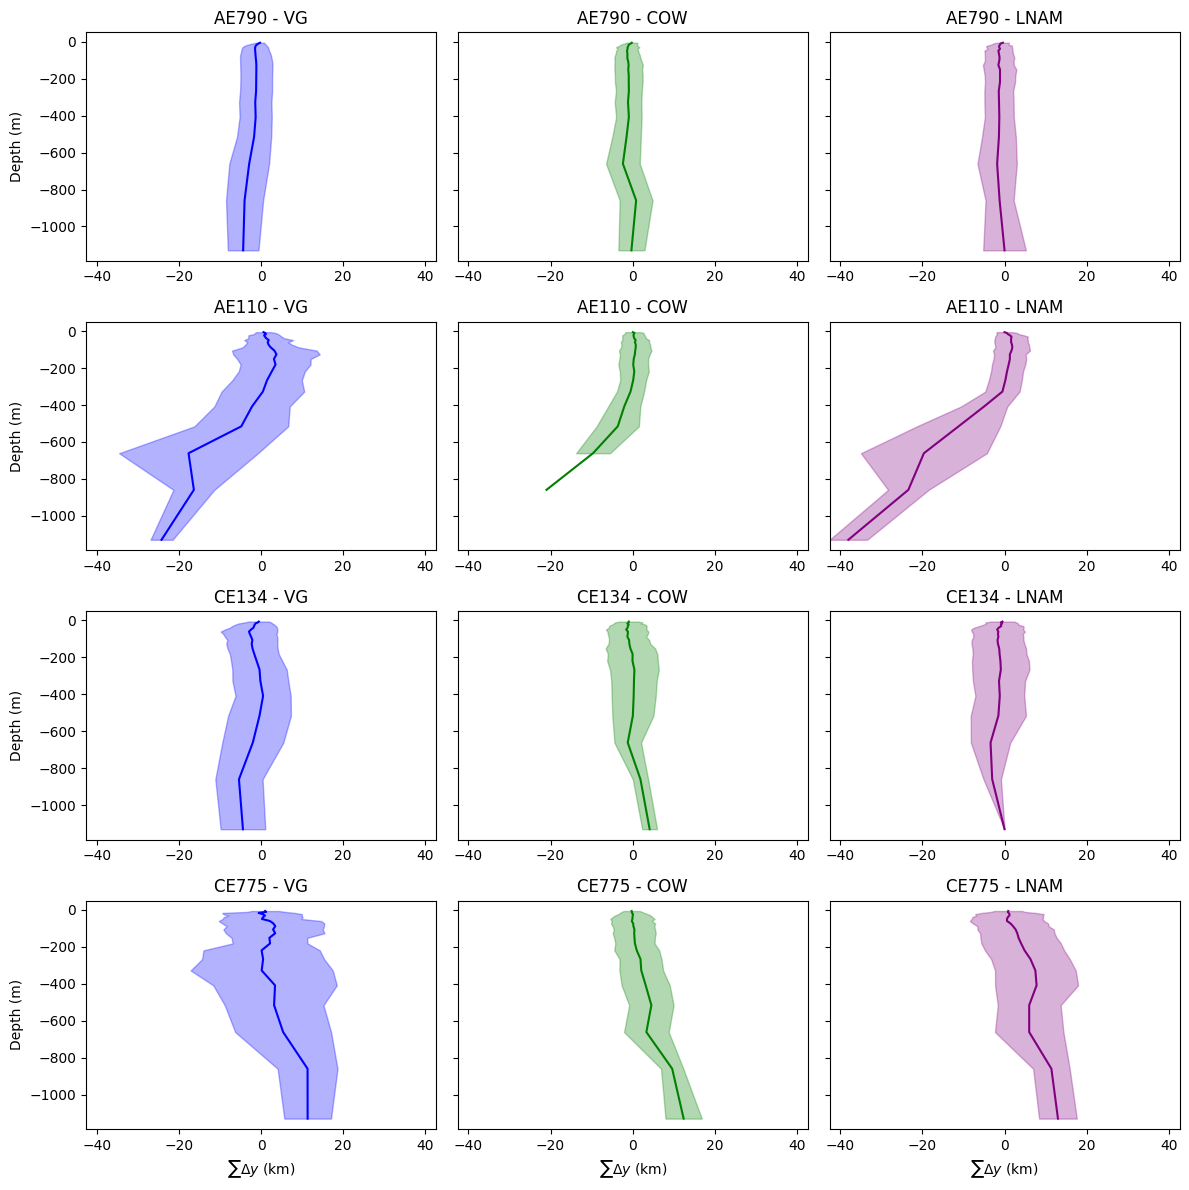

In [95]:
the_frontier_eddies = ['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']

method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        y_df = pd.DataFrame({f'T{t}': frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_df['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y'] for t in range(30)})
        y_mean, y_std = y_df.diff().cumsum().mean(axis=1)/1000, y_df.diff().cumsum().std(axis=1)/1000
        ax.plot(y_mean, z_r[150, 150, :len(y_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(y_mean)], y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta y$ (km)")

        xmin = min(np.nanmin(y_mean - y_std), xmin)
        xmax = max(np.nanmax(y_mean + y_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

## Covariance Analysis

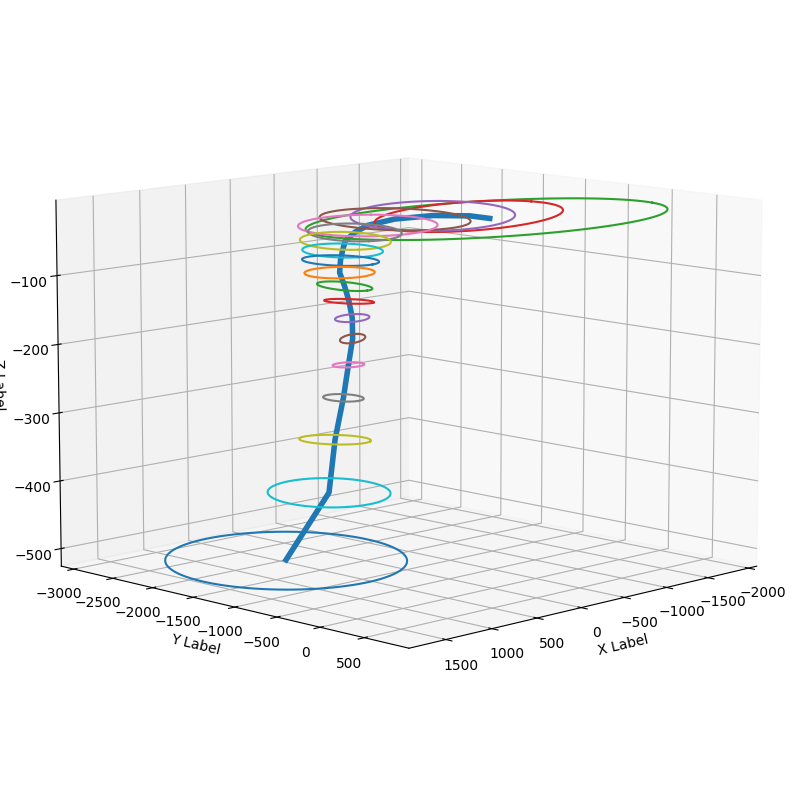

In [218]:
# cap all depth to COWs depth
d_df = pd.DataFrame()
for eddy in the_frontier_eddies:
    for t in range(30):
        df = frontier_sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]

# choose eddy
eddy = the_frontier_eddies[0]

# create x and y dataframes 
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_df['T'+str(t)] = frontier_sample_data[eddy]['T'+str(t)]['VG'].iloc[:d_df['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)]['VG'].iloc[0]['x']
    y_df['T'+str(t)] = frontier_sample_data[eddy]['T'+str(t)]['VG'].iloc[:d_df['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)]['VG'].iloc[0]['y']

# calcualte covariance matrices
Cz = np.full((2, 2, x_df.shape[0]), np.nan)
for k in range(1, x_df.shape[0]):
    x = x_df.diff().iloc[k]
    x = x.loc[~np.isnan(x)]
    y = y_df.diff().iloc[k]
    y = y.loc[~np.isnan(y)]
    Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))

# plot 
x = x_df.diff().mean(axis=1).cumsum()
y = y_df.diff().mean(axis=1).cumsum()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z_r[150, 150, :len(x)], linewidth=4)
for k in range(len(x)):
    C = Cz[:, :, k]
    eigvals, eigvecs = np.linalg.eigh(C)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    axis_lengths = np.sqrt(eigvals)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    ellipse_points = rotation_matrix.dot(ellipse_points)
    ax.plot(ellipse_points[0, :] + x[k], ellipse_points[1, :] + y[k], [z_r[150, 150, k]] * len(ellipse_points[0, :]), label='Covariance Ellipse')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=10, azim=45)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_df, y_df, z_r, and Cz are already defined and contain appropriate data
x = x_df.diff().mean(axis=1).cumsum()
y = y_df.diff().mean(axis=1).cumsum()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# First subplot: x-z projection
ax1 = axes[0]
for k in range(len(x)):
    C = Cz[:, :, k]
    eigvals, eigvecs = np.linalg.eigh(C)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    axis_lengths = np.sqrt(eigvals)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    ellipse_points = rotation_matrix.dot(ellipse_points)
    # Plot the ellipse in x-z projection (keeping x and z)
    ax1.plot(x[k], z_r[150, 150, k], linestyle='-', marker='o', label=f'Eddy {k}')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Z Label')
ax1.set_title('Eddy Plot in x-z Plane')

# Second subplot: y-z projection
ax2 = axes[1]
for k in range(len(y)):
    C = Cz[:, :, k]
    eigvals, eigvecs = np.linalg.eigh(C)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    axis_lengths = np.sqrt(eigvals)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    ellipse_points = rotation_matrix.dot(ellipse_points)
    # Plot the ellipse in y-z projection (keeping y and z)
    ax2.plot(y[k], z_r[150, 150, k], linestyle='-', marker='o', label=f'Eddy {k}')
ax2.set_xlabel('Y Label')
ax2.set_ylabel('Z Label')
ax2.set_title('Eddy Plot in y-z Plane')

# Show the plot
plt.tight_layout()
plt.show()
